# Point Distribution Model

A Point Distribution Model (PDM) is a statistical parametric model of the shape of the deformable obect, which is an essential part for many state-of-the-art deformable models.
Ref: https://www.menpo.org/menpofit/pdm.html

Data: you can download some facial annotated databases from the IBUG website:
http://ibug.doc.ic.ac.uk/resources/facial-point-annotations/
for example LFPW database ("in-the-wild", 811 and 224 training and testing images, respectively). Note that you have to enter your details (name, affiliation, email) before download.

### load all the shapes of LFPW trainset

In [18]:

from pathlib import Path
import menpo.io as mio
from menpo.visualize import print_progress

path_to_lfpw = Path('../Data/lfpw/trainset/')

training_shapes = []
for lg in print_progress(mio.import_landmark_files(path_to_lfpw / '*.pts', verbose=True)):
  # print(lg)
  training_shapes.append(lg['PTS'])

Found 188 assets, index the returned LazyList to import.
[====================] 100% (188/188) - done.                                   


In [19]:
# visualization
%matplotlib inline
from menpowidgets import *
view_widget(training_shapes)

Box(children=(VBox(box_style='warning', children=(HBox(children=(LogoWidget(children=(Image(value=b'\x89PNG\r\…

### construction of a PDM
The construction of a PDM commonly involves the following steps:
1. Align the set of training shapes using Generalized Procrustes Analysis, which will remove the similarity transform components (scaling, in-plane rotation, translation) from the shapes.
2. Apply Principal Component Analysis (PCA) on the aligned shapes. 
3. Further augment the acquired subspace with four eigenvectors that control the global similarity transform of the object, re-orthonormalize [1] and keep the first nn eigenvectors. 
The above procedure can be very easily performed using menpofit's OrthoPDM class as:

In [48]:
from menpofit.modelinstance import OrthoPDM
shape_model = OrthoPDM(training_shapes, max_n_components=None)

# Pring the information about the PCA model that exists in the PDM
print(shape_model)

Point Distribution Model with Similarity Transform 
 - total # components:      136
 - # similarity components: 4
 - # PCA components:        132
 - # active components:     4 + 132 = 136
 - centred:                 True
 - # features:              136
 - kept variance:           3.2e+04  100.0%
 - noise variance:          0.023  0.0%
 - components shape:        (132, 136)



### Active Components
Note that in the previous printing message all the available components are active. This means that when using the model for any kind of operations such as projection or reconstruction, then the whole subspace will be used. Normally, you need to use less components in order to remove the noise that is captured by the last components. This can be done by providing the percentage of variance to be kept as:

In [21]:
shape_model.n_active_components = 0.95

### Generating New Instances
You can generate a new shape instance using only the similarity model (which will naturally apply a similarity transform on the mean shape)

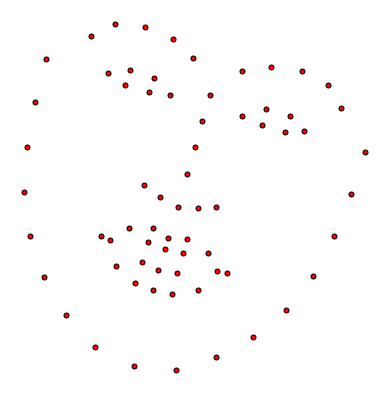

In [22]:
instance = shape_model.similarity_model.instance([100., -300., 0., 0.]) # the input vector is the weights of the model.
instance.view(render_axes=False)

Similarly, a new instance using only the PCA components can be generated as

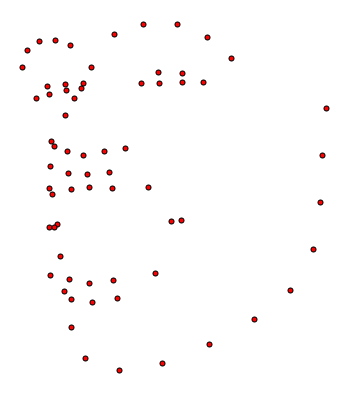

In [23]:
instance = shape_model.model.instance([2., -2., 2., 1.5], normalized_weights=True) # the input vector is the weights of the model.
instance.view(render_axes=False)

Note that in this case, the weights that are provided are normalized with respect to the corresponding eigenvalues.
A combined instance using all the components can be generated by using the from_vector_inplace() method as

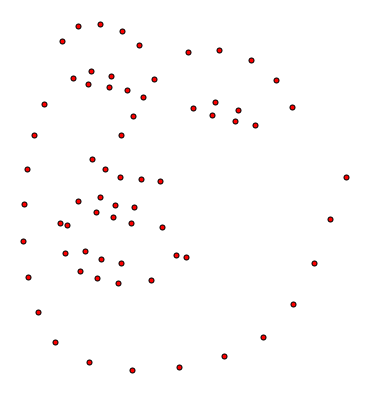

In [24]:
params = [100., -300., 0., 0., 140., -100., 15., 5.] # the weights of the model.
shape_model.from_vector(params).target.view(render_axes=False)

### Visualization
The PCA components of the OrthoPDM can be explored using an interactive widget as:

In [10]:
from menpowidgets import *
view_widget(shape_model.model)

Box(children=(VBox(box_style='warning', children=(LogoWidget(children=(Image(value=b'\x89PNG\r\n\x1a\n\x00\x00…

### Projection and Reconstruction
OrthoPDM makes it very easy to reconstruct a shape instance by setting its target. Let's load Einstein's shape, reconstruct it using the active components (similarity and PCA) and visualize the result:

In [25]:
import matplotlib.pyplot as plt
from menpo.transform import AlignmentAffine

# Import shape and reconstruct
shape = mio.import_builtin_asset.einstein_pts()['PTS']
# shape_model.set_target(shape)

# Find the affine transform that normalizes the shape
# with respect to the mean shape
transform = AlignmentAffine(shape, shape_model.model.mean())

# Normalize shape and project it
normalized_shape = transform.apply(shape)
weights = shape_model.model.project(normalized_shape)
print("Weights: {}".format(weights))

# Reconstruct the normalized shape
reconstructed_normalized_shape = shape_model.model.instance(weights)

# Apply the pseudoinverse of the affine tansform
reconstructed_shape = transform.pseudoinverse().apply(reconstructed_normalized_shape)

Weights: [-136.84485262  -73.98151267   -7.81833933  -34.73137295  -21.15735522
  -47.44280671  -11.9054354     3.48407082   21.22131088   36.5892004
    7.89683819  -16.83138234    6.90658576]


Text(0.5, 1.0, 'Reconstructed shape')

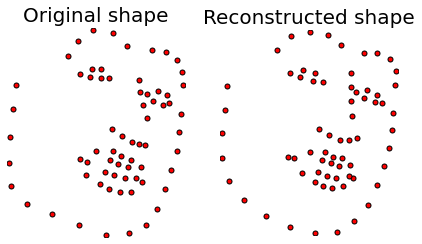

In [47]:
# Visualize
plt.subplot(121)
shape.view(render_axes=False, axes_x_limits=0.01, axes_y_limits=0.01)
plt.gca().set_title('Original shape', fontsize=20)

plt.subplot(122)
reconstructed_shape.view(render_axes=False, axes_x_limits=0.01, axes_y_limits=0.01)
plt.gca().set_title('Reconstructed shape', fontsize=20)